In [46]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import numpy as np
from IPython import display

from tqdm import tqdm

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import matplotlib
matplotlib.rcParams['font.sans-serif'] = "Arial"
matplotlib.rcParams['figure.dpi'] = 80
matplotlib.rcParams['figure.figsize'] = [3.5, 3]
matplotlib.rcParams['axes.grid'] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
# !pip install --upgrade pip --proxy=https://web-proxy.labs.hpecorp.net:8088
import sys
sys.version_info

sys.version_info(major=3, minor=7, micro=7, releaselevel='final', serial=0)

In [14]:
import sys
sys.path.insert(0, '../')

from lib_data import *
from lib_nn_dpe import NN_dpe

In [15]:
load_workspace(vars(), '../data/20190821-051552-mnist_xs')
load_workspace(vars(), '../data/20200130-100802-mnist_config')

Loaded: In, Out, weights, train_images, train_labels, test_images, test_labels, g, img_idx, image, vectors, outputs, software, c, x, y, mat_contents, finalGconv, g1, g2, linear_factors_conv, xs, acc, result, x1, 
Loaded: xs, new_lin_cor_fc1, new_lin_cor_fc2, lin_cor_conv, finalGfc, finalGconv, weights, 


In [16]:
del train_images
del train_labels
# del test_images
# del test_labels
del xs

In [17]:
from lib_ecc import *

## Construct NN

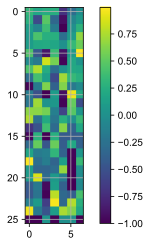

In [18]:
nn = NN_dpe(weights)

nn.Gratio = 100e-6

plt.imshow(nn.Mconv); plt.colorbar()

In [19]:
nn.Gratio

0.0001

## ECC matrix

7 4.0 7.0
The number of redundancy column is chosen to be the smallest even number 8
(26, 15)


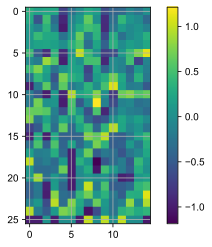

In [20]:
from dpeECC import dpeECC

delta = 1
Delta = 8 * delta

m = nn.Mconv.shape[0]
k = nn.Mconv.shape[1]

print(k, np.ceil(np.sqrt(k+1))+1, 2*k/(np.floor(Delta/(2*delta))-2))

ecc = dpeECC(nn.Mconv, delta, Delta)
M_conv_ecc = ecc.encode()

print('The number of redundancy column is chosen to be the smallest even number', ecc.r)
print(M_conv_ecc.shape)

plt.imshow(M_conv_ecc); plt.colorbar()

Convert to conductance

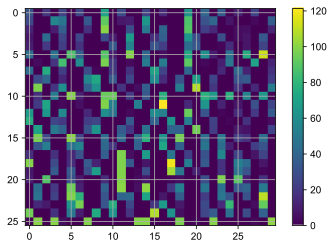

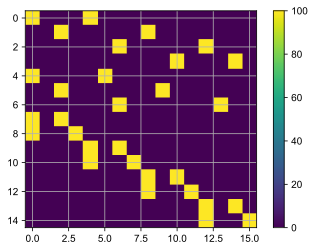

In [21]:
G_conv_ecc = weight2conductance(M_conv_ecc)
G_parity_ecc = weight2conductance(ecc.H.T)

plt.figure(1)
plt.imshow(G_conv_ecc * 1e6); plt.colorbar()

plt.figure(2)
plt.imshow(G_parity_ecc * 1e6); plt.colorbar()

## Plot the difference

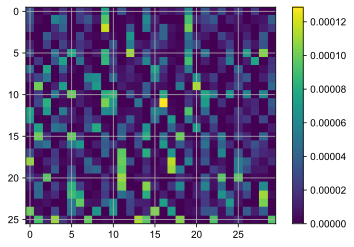

In [40]:
Gsoft = G_conv_ecc + np.random.randn(*G_conv_ecc.shape) * 8e-6
Gsoft[Gsoft<0] = 0

plt.imshow(Gsoft)
plt.colorbar()

In [41]:
rs = G_conv_ecc.shape[0]
cs = G_conv_ecc.shape[1]

i = 0

N_IMG = 10

vectors_list = []
# output_list = []
y1_ideal_list = []
y1_soft_list = []

output_ideal_list = []
output_soft_list = []

for img, lab in tqdm(zip(test_images, test_labels), total=N_IMG):
    i += 1

    vectors = nn._conv_flattern(img)
    
    output_ideal = vectors.T @ G_conv_ecc / nn.Gratio
    output_soft = vectors.T @ Gsoft / nn.Gratio
    
    y1_ideal = output_ideal[:, ::2] - output_ideal[:, 1::2]
    y1_soft  = output_soft[:, ::2]  - output_soft[:, 1::2]
    
    y1_ideal_list.append(y1_ideal)
    y1_soft_list.append(y1_soft)

    vectors_list.append(vectors)
#     output_list.append(output)
    
    if i >= N_IMG:
        break

 90%|███████████████████████████████████████████████████████▊      | 9/10 [00:00<00:00, 72.53it/s]


In [42]:
# img = test_images[0]
# lab = test_labels[0]

# vectors = nn._conv_flattern(img)

# output_ideal = vectors.T @ G_conv_ecc / nn.Gratio
# output_soft = vectors.T @ Gsoft / nn.Gratio

# y1_ideal = output_ideal[:, ::2] - output_ideal[:, 1::2]
# y1_soft  = output_soft[:, ::2]  - output_soft[:, 1::2]

In [59]:
y1_ideal = np.array(y1_ideal_list)
y1_soft = np.array(y1_soft_list)

In [60]:
y1_soft = np.concatenate(y1_soft, axis=0)
y1_ideal = np.concatenate(y1_ideal, axis=0)

Text(0, 0.5, 'Simulated output')

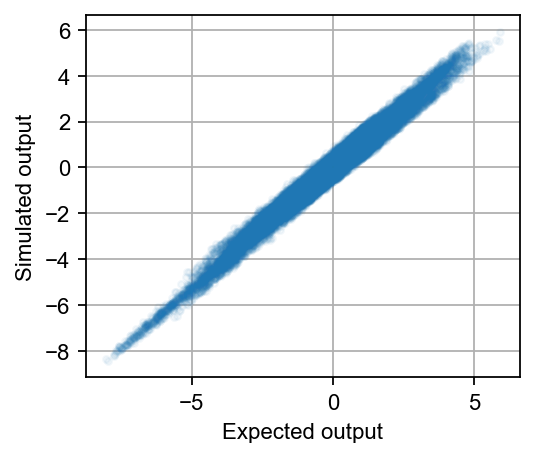

In [61]:
%config InlineBackend.figure_formats = ['retina']

plt.plot(y1_soft.reshape(-1), y1_ideal.reshape(-1), '.', alpha=0.05)
plt.xlabel('Expected output')
plt.ylabel('Simulated output')

Text(0, 0.5, 'Count')

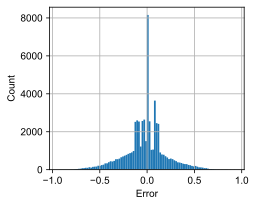

In [62]:
%config InlineBackend.figure_formats = ['svg']

_ = plt.hist(y1_soft.reshape(-1) - y1_ideal.reshape(-1), bins=100)
plt.yscale('linear')

plt.xlabel('Error')
plt.ylabel('Count')

In [63]:
delta = 0.15
Delta = 8 * delta

m = nn.Mconv.shape[0]
k = nn.Mconv.shape[1]

ecc = dpeECC(nn.Mconv, delta, Delta)

In [64]:
y1_ecc = correct_ecc(y1_soft, ecc)

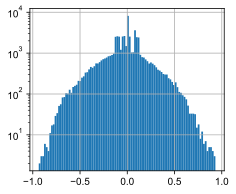

In [65]:
_ = plt.hist(y1_ecc.reshape(-1) - y1_ideal.reshape(-1), bins=100)
plt.yscale('log')

Text(0, 0.5, 'Cummulative number of error')

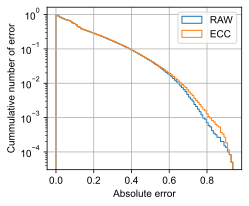

In [66]:
err_soft = (y1_soft - y1_ideal).reshape(-1)
err_ecc = (y1_ecc - y1_ideal).reshape(-1)

_ = plt.hist(abs(err_soft), density=True, histtype='step', cumulative=-1,
        label='RAW', bins=100)

_ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
        label='ECC', bins=100)

plt.legend()

plt.yscale('log')

plt.xlabel('Absolute error')
plt.ylabel('Cummulative number of error')

In [67]:
delta_list = np.arange(0.02, 0.5, 0.02)

y1_ecc_list = []

for delta in tqdm(delta_list):
    Delta = 8 * delta
    ecc = dpeECC(nn.Mconv, delta, Delta)

    y1_ecc_list.append( correct_ecc(y1_soft, ecc) )

100%|█████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 19.18it/s]


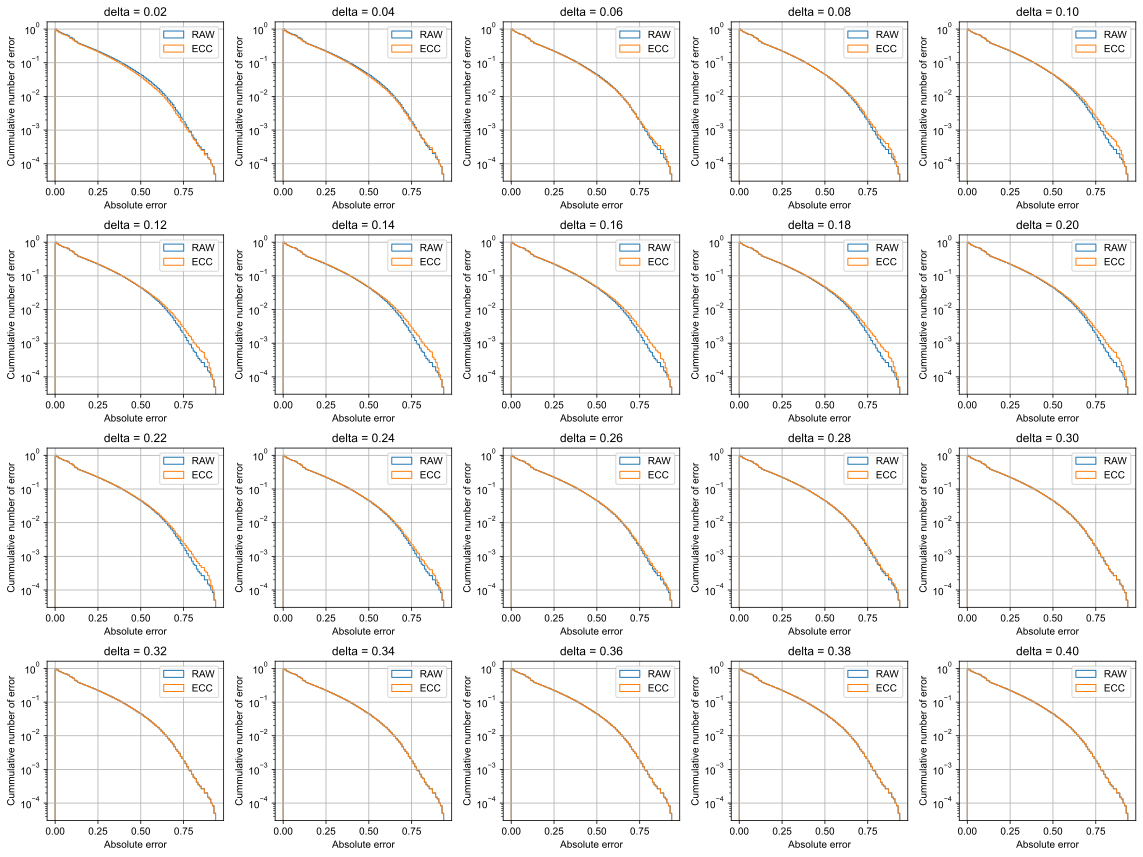

In [72]:
plt.figure(figsize=(16, 12))

for i in range(20):
    
    plt.subplot(4,5,i+1)

    y1_ecc = y1_ecc_list[i]

    err_raw = (y1_soft - y1_ideal).reshape(-1)
    err_ecc = (y1_ecc  - y1_ideal).reshape(-1)


    _ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

    _ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC', bins=100)

    plt.legend()

    plt.yscale('log')
    plt.xlabel('Absolute error')
    plt.ylabel('Cummulative number of error')
    
    plt.title(f'delta = {delta_list[i]:.2f}')
    
plt.tight_layout()

In [59]:
len(y1_ecc_list)

1

## Turn one device

In [158]:
# x = int(np.random.rand() * Gsoft.shape[0])
# y = int(np.random.rand() * Gsoft.shape[1])

x,y = 0,0

Gsoft1 = Gsoft.copy()
Gsoft1[x, y] += 100e-6

In [159]:
img = test_images[0]
lab = test_labels[0]


output_soft1 = vectors.T @ Gsoft1 / nn.Gratio
y1_soft1  = output_soft1[:, ::2]  - output_soft1[:, 1::2]

In [160]:
delta_list = np.arange(0.02, 0.5, 0.02)

y1_ecc_list = []

for delta in tqdm(delta_list):
    Delta = 8 * delta
    ecc = dpeECC(nn.Mconv, delta, Delta)

    y1_ecc_list.append( correct_ecc(y1_soft1, ecc) )

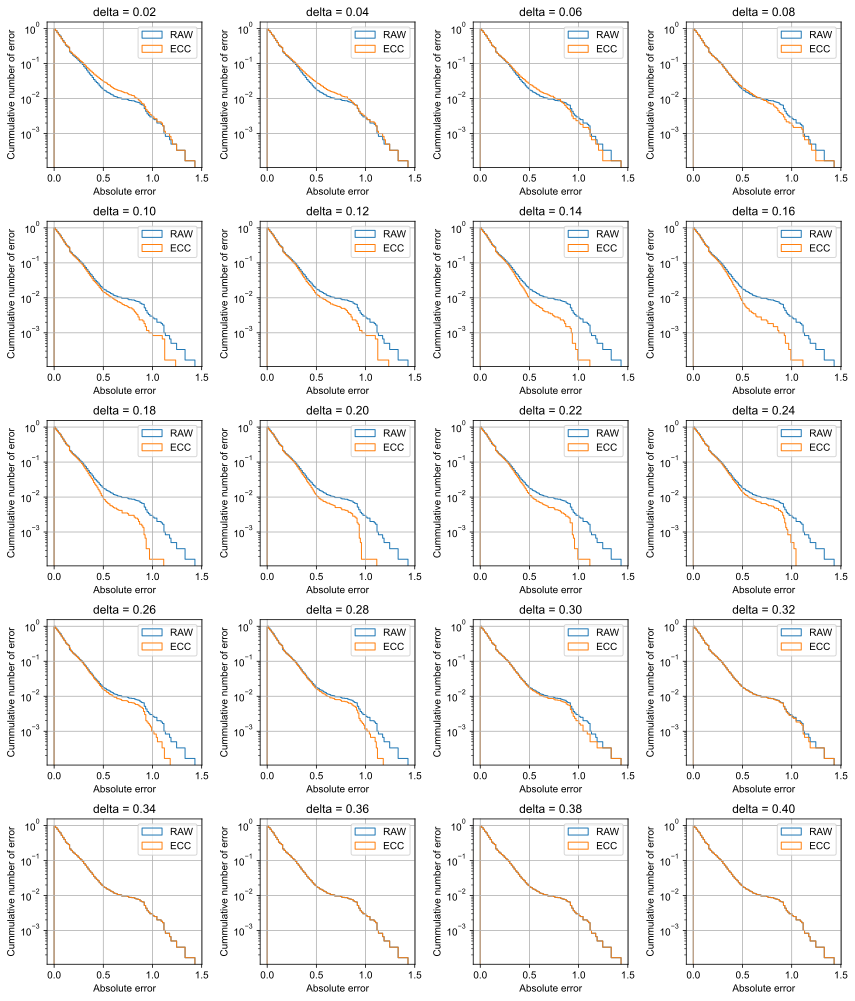

In [161]:
plt.figure(figsize=(12, 14))

for i in range(20):
    
    plt.subplot(5,4,i+1)

    y1_ecc = y1_ecc_list[i]

    err_raw = (y1_soft1 - y1_ideal).reshape(-1)
    err_ecc = (y1_ecc  - y1_ideal).reshape(-1)


    _ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

    _ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC', bins=100)

    plt.legend()

    plt.yscale('log')
    plt.xlabel('Absolute error')
    plt.ylabel('Cummulative number of error')
    
    plt.title(f'delta = {delta_list[i]:.2f}')
    
plt.tight_layout()

## Add noise to the output

In [196]:
y1_soft2 = y1_soft.copy()

for r in range(y1_soft2.shape[0]):
    c = int(y1_soft2.shape[1] * np.random.rand())
    y1_soft2[r,c] += np.random.randn() * 4

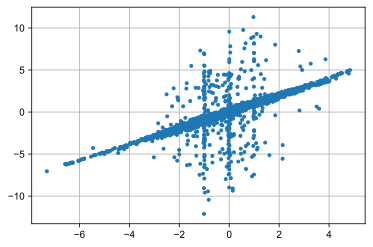

In [200]:
plt.plot(y1_ideal.reshape(-1), y1_soft2.reshape(-1), '.')

In [198]:
delta_list = np.arange(0.02, 0.5, 0.02)

y1_ecc_list = []

for delta in tqdm(delta_list):
    Delta = 8 * delta
    ecc = dpeECC(nn.Mconv, delta, Delta)

    y1_ecc_list.append( correct_ecc(y1_soft2, ecc) )

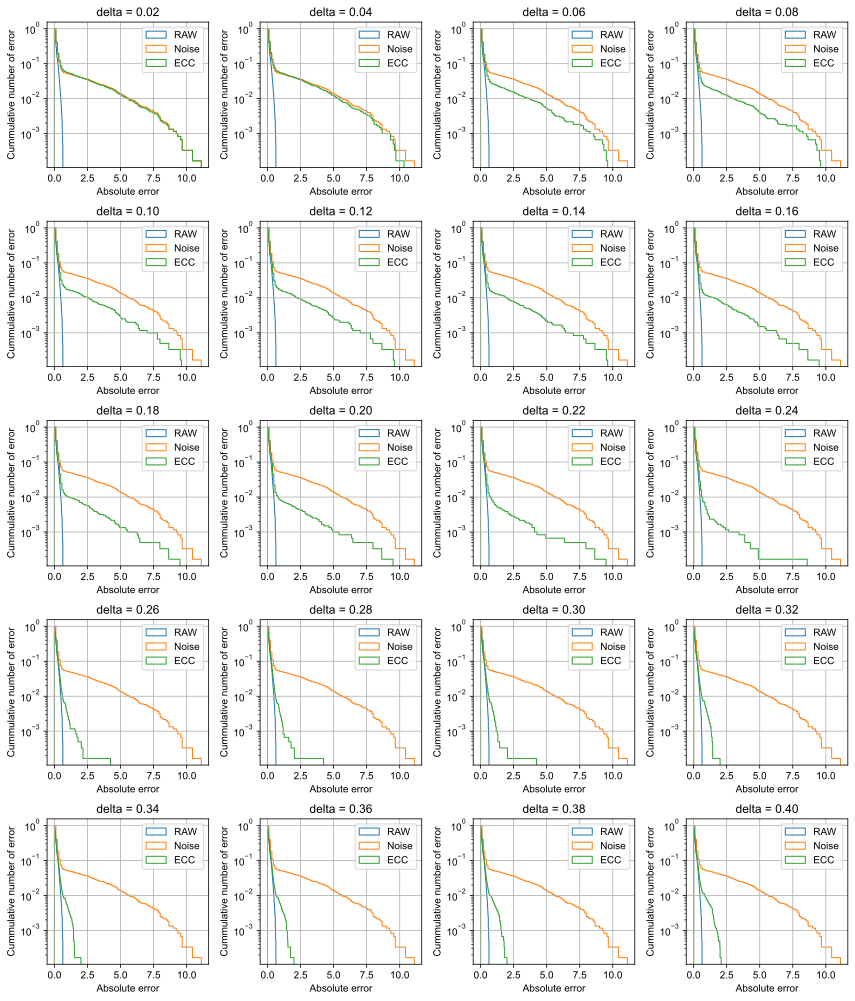

In [199]:
plt.figure(figsize=(12, 14))

for i in range(20):
    
    plt.subplot(5,4,i+1)

    y1_ecc = y1_ecc_list[i]

    err_raw = (y1_soft - y1_ideal).reshape(-1)
    err_noise = (y1_soft2 - y1_ideal).reshape(-1)
    err_ecc = (y1_ecc  - y1_ideal).reshape(-1)


    _ = plt.hist(abs(err_raw), density=True, histtype='step', cumulative=-1,
            label='RAW', bins=100)

    _ = plt.hist(abs(err_noise), density=True, histtype='step', cumulative=-1,
            label='Noise', bins=100)
    
    _ = plt.hist(abs(err_ecc), density=True, histtype='step', cumulative=-1,
            label='ECC', bins=100)

    plt.legend()

    plt.yscale('log')
    plt.xlabel('Absolute error')
    plt.ylabel('Cummulative number of error')
    
    plt.title(f'delta = {delta_list[i]:.2f}')
    
plt.tight_layout()